In [1]:
# ensure classes imported from .py files are dynamically updated
%load_ext autoreload
%autoreload 2

# plot matplots nicely
%matplotlib inline  

In [2]:
import numpy as np
import pandas as pd
import datetime
import xarray as xr
from dateutil.relativedelta import relativedelta
from climate_drought import config, drought_indices as dri, utils
import matplotlib.pyplot as plt
from shapely import Polygon
#pd.set_option('display.max_rows', 500)


C:\Users\eejco\pixalytics\Climate-drought\src\climate-indices\src\climate_indices\utils.py:149: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def reshape_to_2d(
C:\Users\eejco\pixalytics\Climate-drought\src\climate-indices\src\climate_indices\utils.py:199: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def reshape_to_divs_years_months(
C:\Users\eejco\pixalytics\C

In [3]:
# configure inputs
aa = config.AnalysisArgs(latitude=36,longitude=-120,start_date='20200121',end_date='20221231')
#aa = config.AnalysisArgs(latitude=36,longitude=-120,start_date='20191211',end_date='20200101')
#aa = config.AnalysisArgs(latitude=52.5,longitude=1.25,start_date='20200121',end_date='20221231')
cf = config.Config(outdir= 'output',indir='input',verbose=False)

In [4]:
import glob
fpaths = glob.glob('input/smant/*.nc')
fpaths

['input/smant\\smant_m_wld_20200101_20201221_t.nc',
 'input/smant\\smant_m_wld_20210101_20211221_t.nc',
 'input/smant\\smant_m_wld_20220101_20221101_t.nc']

In [5]:
ds_full = xr.open_dataset(fpaths[0]).drop_vars(['4326']) 
lons = [0.5,2.5,2,4.5,3.5]
lats = [2.5,4.5,2,2.5,0.5]
aa = config.AnalysisArgs(latitude=[38.5,40.5,38,38.5,38.5],longitude=[-119.5,-117.5,-118,-117.5,-116.5],start_date='20200121',end_date='20221231')
ds_full

<xarray.Dataset>
Dimensions:  (time: 36, lat: 1800, lon: 3600)
Coordinates:
  * lat      (lat) float64 -89.95 -89.85 -89.75 -89.65 ... 89.75 89.85 89.95
  * lon      (lon) float64 -179.9 -179.8 -179.8 -179.7 ... 179.8 179.8 179.9
  * time     (time) datetime64[ns] 2020-01-01 2020-01-11 ... 2020-12-21
Data variables:
    smant    (time, lat, lon) float32 ...
Attributes: (12/27)
    Source_Software:            dbinterface.py, dbexport.py, netcdf_handling.py
    creator_name:               Carolina Arias Munoz
    Conventions:                CF-1.6
    _CoordSysBuilder:           ucar.nc2.dataset.conv.CF1Convention
    date_created:               2021-09-03
    01.title:                   Ensemble Soil Moisture Anomaly
    ...                         ...
    17.factsheet_url:           https://edo.jrc.ec.europa.eu/documents/factsh...
    18.jrc_data_catalogue_url:  http://data.europa.eu/89h/f4af9315-9581-4403-...
    19.sample_url:              https://edo.jrc.ec.europa.eu/gdo/php/wms.php?...
    20.metadata_last_updated:   2021-07-06
    21.values_legend:           [Less than or equal to -2, -2 to -1.5, -1.5 t...
    22.version_notes:           Current version: Version 2.3.0 covers data fr...

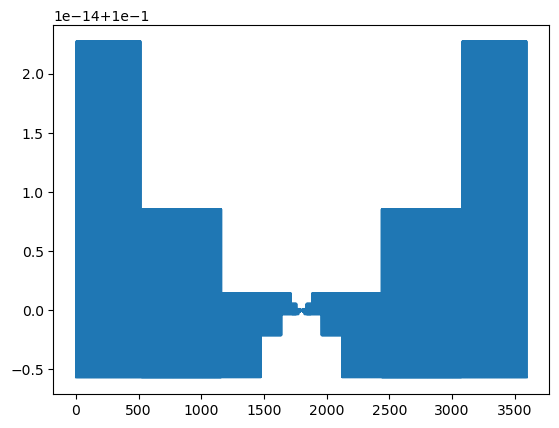

In [6]:
plt.plot(np.diff(ds_full.lon))

In [7]:
grid_x = 0.01
grid_y = 0.01

In [8]:
ds = utils.mask_ds_bbox(ds_full,np.min(lons),np.max(lons),np.min(lats),np.max(lats))

In [9]:
ds

<xarray.Dataset>
Dimensions:  (time: 36, lat: 40, lon: 40)
Coordinates:
  * lat      (lat) float64 0.55 0.65 0.75 0.85 0.95 ... 4.05 4.15 4.25 4.35 4.45
  * lon      (lon) float64 0.55 0.65 0.75 0.85 0.95 ... 4.05 4.15 4.25 4.35 4.45
  * time     (time) datetime64[ns] 2020-01-01 2020-01-11 ... 2020-12-21
Data variables:
    smant    (time, lat, lon) float32 nan nan nan nan nan ... nan nan nan nan
Attributes: (12/27)
    Source_Software:            dbinterface.py, dbexport.py, netcdf_handling.py
    creator_name:               Carolina Arias Munoz
    Conventions:                CF-1.6
    _CoordSysBuilder:           ucar.nc2.dataset.conv.CF1Convention
    date_created:               2021-09-03
    01.title:                   Ensemble Soil Moisture Anomaly
    ...                         ...
    17.factsheet_url:           https://edo.jrc.ec.europa.eu/documents/factsh...
    18.jrc_data_catalogue_url:  http://data.europa.eu/89h/f4af9315-9581-4403-...
    19.sample_url:              https://edo.jrc.ec.europa.eu/gdo/php/wms.php?...
    20.metadata_last_updated:   2021-07-06
    21.values_legend:           [Less than or equal to -2, -2 to -1.5, -1.5 t...
    22.version_notes:           Current version: Version 2.3.0 covers data fr...

In [10]:
xnp = ds['lon'].to_numpy()
ynp = ds['lat'].to_numpy()


In [11]:
# Create a polygon of the area to be masked
pn = Polygon(tuple([(x,y) for x,y in zip(lons,lats)]))

In [12]:
xgrid = grid_x/2
ygrid = grid_y/2
def polycell(x,y):
    """
    Create a new polygon representing the grid cell with centre x,y
    """
    tl = (x-xgrid,y+ygrid)
    tr = (x+xgrid,y+ygrid)
    bl = (x-xgrid,y-ygrid)
    br = (x+xgrid,y-ygrid)
    return Polygon((tl,tr,br,bl))

In [13]:
mask = np.ones((len(ynp),len(xnp))) * np.nan
for i,x in enumerate(xnp):
    for j,y in enumerate(ynp):
        pc = polycell(x,y)
        mask[j,i]=pn.contains(pc) or pn.overlaps(pc)

In [14]:
mask

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [15]:
xx,yy = np.meshgrid(ds.lon,ds.lat)

In [16]:
ynp

array([0.55, 0.65, 0.75, 0.85, 0.95, 1.05, 1.15, 1.25, 1.35, 1.45, 1.55,
       1.65, 1.75, 1.85, 1.95, 2.05, 2.15, 2.25, 2.35, 2.45, 2.55, 2.65,
       2.75, 2.85, 2.95, 3.05, 3.15, 3.25, 3.35, 3.45, 3.55, 3.65, 3.75,
       3.85, 3.95, 4.05, 4.15, 4.25, 4.35, 4.45])

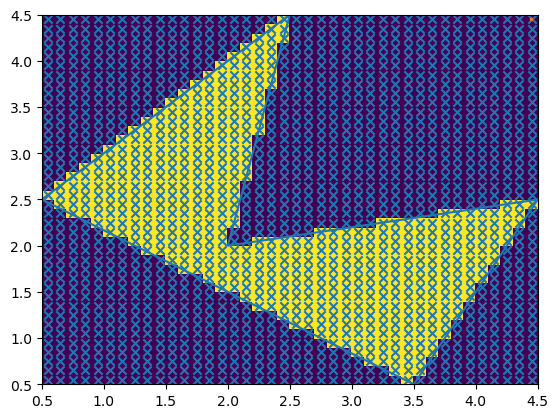

In [17]:
fig,ax = plt.subplots()
ax.pcolor(xnp,ynp,mask)
ax.scatter(xx,yy,marker='x')
px,py = pn.exterior.xy
ax.plot(px,py)
pcx,pcy = pc.exterior.xy
ax.plot(pcx,pcy)

In [19]:
test = utils.mask_ds_poly(ds_full,lats,lons,grid_x,grid_y,-99999)

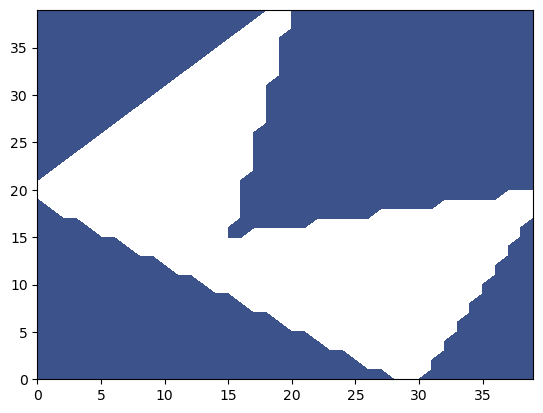

In [21]:
plt.contourf(test.smant.isel(time=0))

In [23]:
sma = dri.SMA_GDO(cf,aa)
sma.download()

2023-06-01  11:32:48 INFO Successfully retrieved URL for GDO file with year: 2020, prod_code smant
2023-06-01  11:32:48 INFO Couldn't retrieve URL for GDO file with year: 2020, prod_code smand
2023-06-01  11:32:48 INFO Successfully retrieved URL for GDO file with year: 2021, prod_code smant
2023-06-01  11:32:48 INFO Couldn't retrieve URL for GDO file with year: 2021, prod_code smand
2023-06-01  11:32:49 INFO Successfully retrieved URL for GDO file with year: 2022, prod_code smant
2023-06-01  11:32:49 INFO Couldn't retrieve URL for GDO file with year: 2022, prod_code smand
2023-06-01  11:32:49 INFO File already exists at: input/smant/smant_m_wld_20200101_20201221_t.nc
2023-06-01  11:32:49 INFO File already exists at: input/smant/smant_m_wld_20210101_20211221_t.nc
2023-06-01  11:32:49 INFO File already exists at: input/smant/smant_m_wld_20220101_20221101_t.nc
2023-06-01  11:32:49 INFO Could not download file: input/smant/smant_m_wld_20220101_20220921_t.nc
2023-06-01  11:32:49 INFO Error:

In [24]:
ds = sma.load_and_trim()

In [26]:
df = ds.to_dataframe()
time_months = pd.date_range(aa.start_date,aa.end_date,freq='1MS')
df = utils.fill_gaps(time_months,df)

NameError: name 'self' is not defined

In [ ]:

xnp = ds[ds_lon_name].to_numpy()
ynp = ds[ds_lon_name].to_numpy()

# Define the size of each grid cell
ygrid = np.round(xnp[1]-xnp[0],2)#np.mean(np.diff(xnp))/2
xgrid = np.round(ynp[1]-ynp[0],2)#np.mean(np.diff(ynp))/2



def gridcellinpoly(coords):
    """
    Compute if grid cell centred at x,y has any overlap with the area to be masked
    """
    pc = polycell(coords[0],coords[1])
    return pn.overlaps(pc)

# Vectorize method so we can perform it across 2D lat and lon grids
vgcip = np.vectorize(gridcellinpoly)

# Create 2D lat and lon grids
xx, yy = np.meshgrid(xnp,ynp)
coords = [[[x,y] for x in xnp] for y in ynp]
mask = [[gridcellinpoly(i) for i in lat] for lat in coords]

In [21]:
masked = utils.mask_ds_poly(ds,lats,lons)

In [8]:
masked

<xarray.Dataset>
Dimensions:  (time: 36, lat: 10, lon: 20)
Coordinates:
  * lat      (lat) float64 0.05 0.15 0.25 0.35 0.45 0.55 0.65 0.75 0.85 0.95
  * lon      (lon) float64 0.05 0.15 0.25 0.35 0.45 ... 1.55 1.65 1.75 1.85 1.95
  * time     (time) datetime64[ns] 2015-01-01 2015-01-11 ... 2015-12-21
Data variables:
    smant    (time, lat, lon) float32 nan nan nan nan nan ... nan nan nan nan
    mask     (lat, lon) float64 nan nan nan nan nan nan ... nan nan nan 1.0 1.0
Attributes: (12/27)
    Source_Software:            dbinterface.py, dbexport.py, netcdf_handling.py
    creator_name:               Carolina Arias Munoz
    Conventions:                CF-1.6
    _CoordSysBuilder:           ucar.nc2.dataset.conv.CF1Convention
    date_created:               2021-09-02
    01.title:                   Ensemble Soil Moisture Anomaly
    ...                         ...
    17.factsheet_url:           https://edo.jrc.ec.europa.eu/documents/factsh...
    18.jrc_data_catalogue_url:  http://data.europa.eu/89h/f4af9315-9581-4403-...
    19.sample_url:              https://edo.jrc.ec.europa.eu/gdo/php/wms.php?...
    20.metadata_last_updated:   2021-07-06
    21.values_legend:           [Less than or equal to -2, -2 to -1.5, -1.5 t...
    22.version_notes:           Current version: Version 2.3.0 covers data fr...

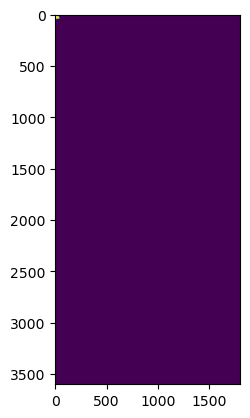

In [ ]:
from shapely.geometry import Polygon
import rasterio.features
import matplotlib.pyplot as plt

poly = Polygon([(0, 50), (10, 10), (30, 0), (45, 45), (0, 50)])
img = rasterio.features.rasterize([poly], out_shape=(len(ds.lon), len(ds.lat)))
plt.imshow(img)

In [10]:
img

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

In [257]:

pn = Polygon(tuple([(x,y) for x,y in zip(longitude,latitude)]))
px,py = pn.exterior.xy

In [209]:
xx, yy = np.meshgrid(ds.lon, ds.lat)
ds['mask'] = (('lat','lon'),contains(Polygon(tuple([(x,y) for x,y in zip(longitude,latitude)])), xx, yy))

In [210]:
ds['xx'] = (('lat','lon'),xx)

In [236]:
x = ds.lon.to_numpy()
y = ds.lat.to_numpy()
midx = (x[:-1] + x[1:]) / 2
midy = (y[:-1] + y[1:]) / 2
mxx, myy = np.meshgrid(midx,midy)


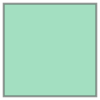

In [244]:
ygrid = np.mean(np.diff(ds.lat))/2
xgrid = np.mean(np.diff(ds.lon))/2
def polycell(x,y):
    tl = (x-xgrid,y+ygrid)
    tr = (x+xgrid,y+ygrid)
    bl = (x-xgrid,y-ygrid)
    br = (x+xgrid,y-ygrid)
    return Polygon((tl,tr,br,bl))
polycell(1,32)

In [283]:
def gridcellinpoly(x,y):
    pc = polycell(x,y)
    return pn.overlaps(pc)

In [284]:
vgcip = np.vectorize(gridcellinpoly)

In [285]:
mask = vgcip(xx,yy)

(-3.0, 3.0)

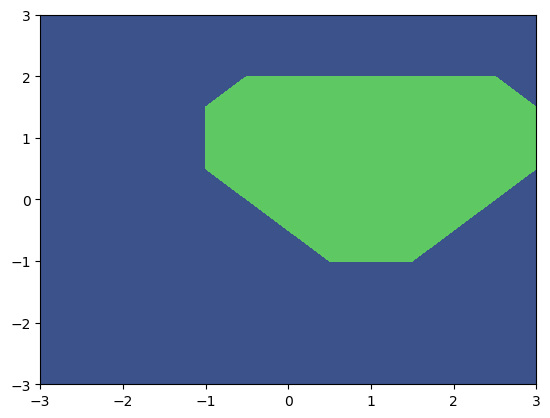

In [280]:
plt.contourf(ds.lon,ds.lat,mask)
plt.xlim([-3,3])
plt.ylim([-3,3])

In [271]:
map(gridcellinpoly,xx,yy)

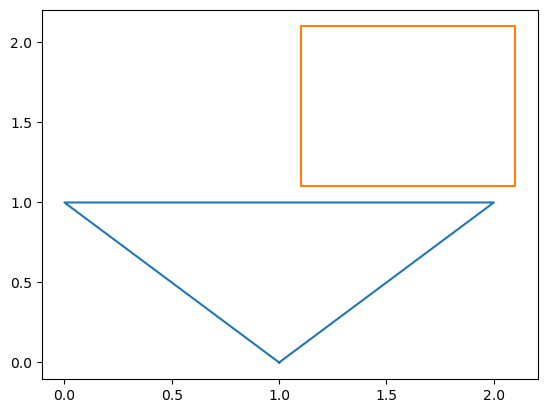

In [286]:
pcx,pcy = polycell(1.6,1.6).exterior.xy
fig, ax = plt.subplots()
ax.plot(px,py)
ax.plot(pcx,pcy)

In [28]:
tmp = (ds['lon'] >= 0) & (ds['lon'] <=10)
ds.where(tmp,drop=True)

<xarray.Dataset>
Dimensions:  (time: 36, lat: 1800, lon: 100)
Coordinates:
  * lat      (lat) float64 -89.95 -89.85 -89.75 -89.65 ... 89.75 89.85 89.95
  * lon      (lon) float64 0.05 0.15 0.25 0.35 0.45 ... 9.55 9.65 9.75 9.85 9.95
  * time     (time) datetime64[ns] 2015-01-01 2015-01-11 ... 2015-12-21
Data variables:
    smant    (time, lat, lon) float32 nan nan nan nan nan ... nan nan nan nan
Attributes: (12/27)
    Source_Software:            dbinterface.py, dbexport.py, netcdf_handling.py
    creator_name:               Carolina Arias Munoz
    Conventions:                CF-1.6
    _CoordSysBuilder:           ucar.nc2.dataset.conv.CF1Convention
    date_created:               2021-09-02
    01.title:                   Ensemble Soil Moisture Anomaly
    ...                         ...
    17.factsheet_url:           https://edo.jrc.ec.europa.eu/documents/factsh...
    18.jrc_data_catalogue_url:  http://data.europa.eu/89h/f4af9315-9581-4403-...
    19.sample_url:              https://edo.jrc.ec.europa.eu/gdo/php/wms.php?...
    20.metadata_last_updated:   2021-07-06
    21.values_legend:           [Less than or equal to -2, -2 to -1.5, -1.5 t...
    22.version_notes:           Current version: Version 2.3.0 covers data fr...

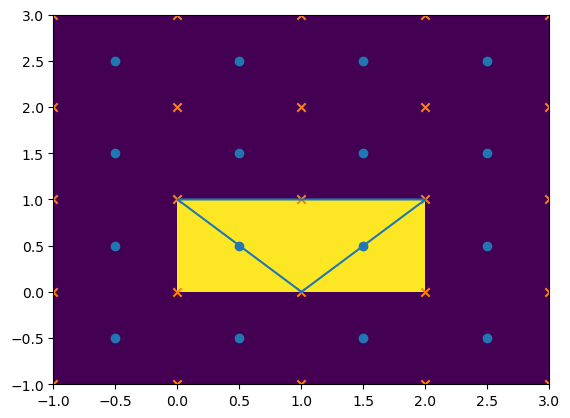

In [288]:
fig, ax = plt.subplots()
ax.pcolor(ds.lon,ds.lat,mask)
#ax.contourf(xx)
ax.plot(px,py)
ax.set_xlim([-1,3])
ax.set_ylim([-1,3])
ax.scatter(xx,yy)
ax.scatter(mxx,myy,marker='x')

In [159]:
# Methods to open data
if isinstance(longitude,list):
    polygon = Polygon(tuple([(x,y) for x,y in zip(longitude,latitude)]))
    def open(fname):
        ds = xr.open_dataset(fname).drop_vars(['4326']) 
        x, y = np.meshgrid(ds.lon, ds.lat)
        ds['mask'] = (('lat','lon'),contains(polygon, x, y))
        return ds.where(ds.mask,drop=True).drop_vars(['mask'])
else:
    def open(fname):
        return xr.open_dataset(fname).sel(lat=latitude,lon=longitude,method='nearest').drop_vars(['4326']) 

# Open all dses and merge
df = xr.merge(open(fname) for fname in fpaths)#.to_dataframe()


Traceback (most recent call last):
  File "_pydevd_bundle/pydevd_cython.pyx", line 577, in _pydevd_bundle.pydevd_cython.PyDBFrame._handle_exception
  File "_pydevd_bundle/pydevd_cython.pyx", line 312, in _pydevd_bundle.pydevd_cython.PyDBFrame.do_wait_suspend
  File "c:\Users\jenni\anaconda3\envs\climate_env\lib\site-packages\debugpy\_vendored\pydevd\pydevd.py", line 2070, in do_wait_suspend
    keep_suspended = self._do_wait_suspend(thread, frame, event, arg, suspend_type, from_this_thread, frames_tracker)
  File "c:\Users\jenni\anaconda3\envs\climate_env\lib\site-packages\debugpy\_vendored\pydevd\pydevd.py", line 2106, in _do_wait_suspend
    time.sleep(0.01)
KeyboardInterrupt


ValueError: Cannot apply_along_axis when any iteration dimensions are 0

In [141]:
# Trim to required dates
df = df.where((df.time >= pd.Timestamp('20200101')) & (df.time <= pd.Timestamp('20230101')),drop=True)

In [143]:
newdates = pd.date_range('20200101','20230101',freq='1MS')
def fill_gaps(index, df: pd.DataFrame) -> pd.DataFrame:
    """
    Utility function to populate missing data in a DataFrame against a defined list of times
    :param index: index we want to populate 
    :param df: pd.DataFrame to be interpolated onto index
    :return: pd.DataFrame with a regular datetime index where missing data is populated with NaNs
    """
    gaps = index[~index.isin(df.index)]
    if len(gaps) > 0:
        df_gaps = pd.DataFrame(index=gaps)
        return pd.concat([df,df_gaps]).sort_index()
    else:
        return df
    
def file_time_gaps_ds(index, ds: xr.Dataset) -> xr.Dataset:
    """
    Utility function to populate missing data in a Dataset against a defined list of times
    :param index: index we want to populate 
    :param ds: xr.Dataset to be interpolated onto index
    :return: xr.Dataset with a regular time coordinate where missing data is populated with NaNs
    """
    gaps = index[~index.isin(ds.time)]
    if len(gaps) > 0:
        ds = pd.DataFrame(index=gaps)
        return pd.concat([df,df_gaps]).sort_index()
    else:
        return df
    

In [146]:
newdates = utils.dti_dekads(self.args.start_date,self.args.end_date)#pd.date_range('20200101','20230101',freq='1MS')
len(newdates)

37

In [153]:
ds.time.to_dataframe().index

DatetimeIndex(['2020-01-01', '2020-01-11', '2020-01-21', '2020-02-01',
               '2020-02-11', '2020-02-21', '2020-03-01', '2020-03-11',
               '2020-03-21', '2020-04-01', '2020-04-11', '2020-04-21',
               '2020-05-01', '2020-05-11', '2020-05-21', '2020-06-01',
               '2020-06-11', '2020-06-21', '2020-07-01', '2020-07-11',
               '2020-07-21', '2020-08-01', '2020-08-11', '2020-08-21',
               '2020-09-01', '2020-09-11', '2020-09-21', '2020-10-01',
               '2020-10-11', '2020-10-21', '2020-11-01', '2020-11-11',
               '2020-11-21', '2020-12-01', '2020-12-11', '2020-12-21'],
              dtype='datetime64[ns]', name='time', freq=None)

In [154]:
gaps = newdates[~newdates.isin(ds.time.to_dataframe().index)]
gaps

DatetimeIndex(['2021-01-01', '2021-02-01', '2021-03-01', '2021-04-01',
               '2021-05-01', '2021-06-01', '2021-07-01', '2021-08-01',
               '2021-09-01', '2021-10-01', '2021-11-01', '2021-12-01',
               '2022-01-01', '2022-02-01', '2022-03-01', '2022-04-01',
               '2022-05-01', '2022-06-01', '2022-07-01', '2022-08-01',
               '2022-09-01', '2022-10-01', '2022-11-01', '2022-12-01',
               '2023-01-01'],
              dtype='datetime64[ns]', freq='MS')

In [32]:
from shapely.vectorized import contains
ds.assign(mask=contains(pn, x, y),dims,drop=True)

MissingDimensionsError: cannot set variable 'mask' with 2-dimensional data without explicit dimension names. Pass a tuple of (dims, data) instead.

In [18]:
points = ds.assign(points=lambda x: Point(x.lat, x.lon))

TypeError: only size-1 arrays can be converted to Python scalars

In [15]:
def pointinpoly(lat,lon):
    func = lambda lat,lon: pn.contains(Point(lat,lon))
    return xr.apply_ufunc(func, lat, lon)

In [16]:
pointinpoly(ds.lat, ds.lon)

TypeError: only size-1 arrays can be converted to Python scalars

In [33]:
geometries[0]

{'type': 'Polygon',
 'coordinates': [[[1, 52], [2, 53], [2, 54], [1, 54], [0, 53]]]}

In [4]:
sma = dri.SMA_GDO(cf,aa)
sma.download()

2023-05-25  15:28:24 INFO Successfully retrieved URL for GDO file with year: 2020, prod_code smant
2023-05-25  15:28:29 INFO Couldn't retrieve URL for GDO file with year: 2020, prod_code smand
2023-05-25  15:28:29 INFO Successfully retrieved URL for GDO file with year: 2021, prod_code smant
2023-05-25  15:28:35 INFO Couldn't retrieve URL for GDO file with year: 2021, prod_code smand
2023-05-25  15:28:35 INFO Successfully retrieved URL for GDO file with year: 2022, prod_code smant
2023-05-25  15:28:35 INFO Couldn't retrieve URL for GDO file with year: 2022, prod_code smand
2023-05-25  15:28:35 INFO File already exists at: input/smant/smant_m_wld_20200101_20201221_t.nc
2023-05-25  15:28:35 INFO File already exists at: input/smant/smant_m_wld_20210101_20211221_t.nc
2023-05-25  15:28:35 INFO File already exists at: input/smant/smant_m_wld_20220101_20221101_t.nc
2023-05-25  15:28:36 INFO Could not download file: input/smant/smant_m_wld_20220101_20220921_t.nc
2023-05-25  15:28:36 INFO Error:

In [5]:
sma.process()

In [35]:
cdi = dri.CDI(cf,config.CDIArgs(aa.latitude,aa.longitude,aa.start_date,aa.end_date,spi_source='GDO'))
cdi.process()

2023-05-04  12:38:51 INFO Computing Combined Drought Indicator...
2023-05-04  12:38:53 WARNING Outfile not written: already exists
2023-05-04  12:38:55 WARNING Outfile not written: already exists
2023-05-04  12:38:55 INFO Completed processing of ERA5 CDI data.


,spg03,smant,fpanv,CDI
2019-12-01,NaN,NaN,NaN,NaN
2019-12-11,NaN,NaN,NaN,NaN
2019-12-21,NaN,NaN,NaN,NaN
2020-01-01,0.126,NaN,NaN,NaN
2020-01-11,0.126,NaN,NaN,NaN
...,...,...,...,...
2022-11-11,-0.236,-0.79,0.239,0.0
2022-11-21,-0.236,0.52,0.420,0.0
2022-12-01,-0.277,NaN,0.542,NaN
2022-12-11,-0.277,NaN,0.692,NaN


In [22]:
cdi = dri.CDI(cf,config.CDIArgs(aa.latitude,aa.longitude,aa.start_date,aa.end_date,sma_source='ECMWF',sma_var='zscore_swvl3'))
cdi.process()

2023-05-01  14:52:40 INFO Computing Combined Drought Indicator...
2023-05-01  14:52:40 INFO Initiating processing of ERA5 daily data.
2023-05-01  14:52:40 INFO Input precipitation, 456 values: 0.000 0.005 
2023-05-01  14:52:40 INFO 

2023-05-01  14:52:40 DEBUG scaled values: 0.002 0.012
2023-05-01  14:52:40 DEBUG alphas: 9.687 17.504 betas: 0.000 0.001
2023-05-01  14:52:40 INFO SPI, 456 values: -3.046 2.676
2023-05-01  14:52:40 INFO Initiating processing of ERA5 soil water data.
2023-05-01  14:52:40 INFO Completed processing of ERA5 soil water data.
2023-05-01  14:52:42 INFO Completed processing of ERA5 fAPAR data.
2023-05-01  14:52:42 INFO Completed processing of ERA5 CDI data.


,tp,spi,swvl2,swvl4,swvl3,swvl1,zscore_swvl1,zscore_swvl2,zscore_swvl3,zscore_swvl4,fpanv,CDI
2019-12-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-12-11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-12-21,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-01,0.002574,1.760415,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-11,0.002574,1.760415,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
2022-11-11,0.000909,-1.089360,0.331300,0.307727,0.236064,0.353820,0.998224,0.596497,-1.009529,-0.387874,1.78,2.0
2022-11-21,0.000909,-1.089360,0.370814,0.306952,0.274808,0.376866,1.483593,1.348706,-0.272406,-0.422276,NaN,NaN
2022-12-01,0.002387,-0.953641,0.366576,0.306847,0.314400,0.369212,1.322389,1.268030,0.480835,-0.426949,NaN,NaN
2022-12-11,0.002387,-0.953641,0.383465,0.308668,0.352771,0.382669,1.605801,1.589532,1.210864,-0.346117,NaN,NaN


<Axes: >

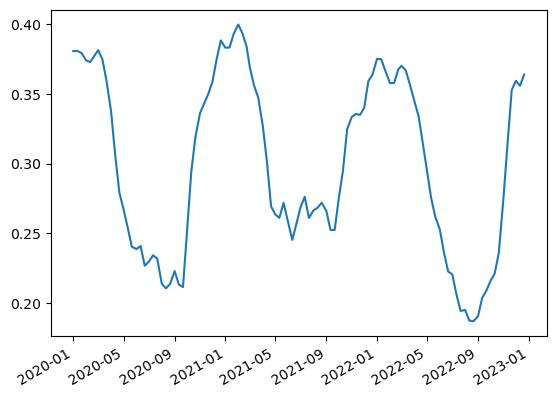

In [6]:
sma.data.swvl3.plot()

In [7]:
sdate_ts = pd.Timestamp(aa.start_date)
sdate_dk = sdate_ts.replace(day=utils.nearest_dekad(sdate_ts.day))
sdate_sma = sdate_dk - relativedelta(days=20)

In [8]:
def aa_new(required_sdate: pd.Timestamp) -> config.AnalysisArgs:
    """
    Helper function to quickly return modified arguments
    """
    # Makes sure start date is in dekads and the required format
    sdate = required_sdate.replace(day=utils.nearest_dekad(required_sdate.day))
    return config.AnalysisArgs(aa.latitude,aa.longitude,sdate.strftime('%Y%m%d'),aa.end_date)


In [10]:
tmp = dri.SMA_ECMWF(cf,aa_new(sdate_sma))

In [11]:
fpath = tmp.download_obj_hourly.download_file_path
fpath

'output\\soilwater_20191211-20221231_52.5_1.25_hourly.nc'

In [13]:
myfile='output/soilwater_20191211-20221231_52.5_1.25_hourly.nc'

In [15]:
xr.open_dataset(myfile).swvl3#.plot()

<xarray.DataArray 'swvl3' (time: 26808, latitude: 1, longitude: 1)>
[26808 values with dtype=float32]
Coordinates:
  * longitude  (longitude) float32 1.15
  * latitude   (latitude) float32 52.4
  * time       (time) datetime64[ns] 2019-12-11T13:00:00 ... 2022-12-31T01:00:00
Attributes:
    units:      m**3 m**-3
    long_name:  Volumetric soil water layer 3

<Axes: >

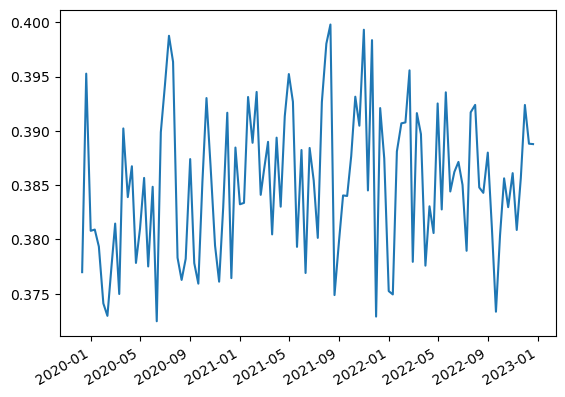

In [9]:
cdi.sma.data.swvl3.plot()

In [57]:
cdi.index_shortname(caps=False)

TypeError: 'str' object is not callable

In [54]:

cdi.download()
cdi.process()

2023-04-17  13:16:27 INFO Downloaded file 'output\precip_19850101-20221231_monthly_52.5_1.25.nc' already exists.
2023-04-17  13:16:27 INFO Downloaded files available.
2023-04-17  13:16:27 INFO Downloaded files available.
2023-04-17  13:16:27 INFO Computing Combined Drought Indicator...
2023-04-17  13:16:27 INFO Initiating processing of ERA5 daily data.
2023-04-17  13:16:27 INFO Input precipitation, 456 values: 0.000 0.005 
2023-04-17  13:16:27 INFO 

2023-04-17  13:16:27 DEBUG scaled values: 0.002 0.012
2023-04-17  13:16:27 DEBUG alphas: 9.687 17.504 betas: 0.000 0.001
2023-04-17  13:16:27 INFO SPI, 456 values: -3.046 2.676
2023-04-17  13:16:29 INFO Completed processing of ERA5 soil water data.
2023-04-17  13:16:31 INFO Completed processing of ERA5 fAPAR data.
2023-04-17  13:16:31 INFO Completed processing of ERA5 CDI data.


,tp,spi,smant,fpanv,CDI
2020-01-01,NaN,NaN,NaN,NaN,NaN
2020-01-11,NaN,NaN,NaN,NaN,NaN
2020-01-21,NaN,NaN,NaN,NaN,NaN
2020-02-01,0.001882,0.928141,NaN,NaN,NaN
2020-02-11,0.001882,0.928141,-0.08,-1.078,0.0
...,...,...,...,...,...
2022-11-11,0.000909,-1.089360,-1.81,1.780,2.0
2022-11-21,0.000909,-1.089360,-0.40,NaN,NaN
2022-12-01,0.002387,-0.953641,NaN,NaN,NaN
2022-12-11,0.002387,-0.953641,NaN,NaN,NaN


In [35]:
warns = []
for i,r in cdi.df_shifted.iterrows():
    spi_warn = r['spi'] < -1
    warns.append(r['spi'] < -1)

In [48]:
cdi.df_shifted.isna().any(axis=1)

2020-01-01     True
2020-01-11     True
2020-01-21     True
2020-02-01     True
2020-02-11    False
              ...  
2022-11-11    False
2022-11-21     True
2022-12-01     True
2022-12-11     True
2022-12-21     True
Length: 108, dtype: bool

In [53]:

def calc_cdi(r):
    spi_ = r['spi'] < -1
    sma_ = r['smant'] < -1
    fpr_ = r['fpanv'] < -1
    if r.isna().any():
        return np.nan
    elif spi_ and sma_ and fpr_:
        return 4
    elif spi_ and fpr_:
        return 3
    elif spi_ and sma_:
        return 2
    elif spi_:
        return 1
    else:
        return 0
    
cdi.df_shifted.apply(calc_cdi,axis=1)

2020-01-01    NaN
2020-01-11    NaN
2020-01-21    NaN
2020-02-01    NaN
2020-02-11    0.0
             ... 
2022-11-11    2.0
2022-11-21    NaN
2022-12-01    NaN
2022-12-11    NaN
2022-12-21    NaN
Length: 108, dtype: float64

In [14]:
(cdi.sma_shifted < -1).to_numpy().flatten()

array([False, False, False, False, False, False, False,  True,  True,
        True, False, False,  True,  True,  True, False, False, False,
       False, False,  True, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False,  True,  True,  True,
        True,  True,  True,  True,  True,  True, False, False, False,
        True, False, False, False, False])

In [ ]:
from rasterio import features
from affine import Affine

def transform_from_latlon(lat, lon):
    """ input 1D array of lat / lon and output an Affine transformation
    """
    lat = np.asarray(lat)
    lon = np.asarray(lon)
    trans = Affine.translation(lon[0], lat[0])
    scale = Affine.scale(lon[1] - lon[0], lat[1] - lat[0])
    return trans * scale

def rasterize(shapes, coords, latitude='latitude', longitude='longitude',
              fill=np.nan, **kwargs):
    """Rasterize a list of (geometry, fill_value) tuples onto the given
    xray coordinates. This only works for 1d latitude and longitude
    arrays.

    usage:
    -----
    1. read shapefile to geopandas.GeoDataFrame
          `states = gpd.read_file(shp_dir+shp_file)`
    2. encode the different shapefiles that capture those lat-lons as different
        numbers i.e. 0.0, 1.0 ... and otherwise np.nan
          `shapes = (zip(states.geometry, range(len(states))))`
    3. Assign this to a new coord in your original xarray.DataArray
          `ds['states'] = rasterize(shapes, ds.coords, longitude='X', latitude='Y')`

    arguments:
    ---------
    : **kwargs (dict): passed to `rasterio.rasterize` function

    attrs:
    -----
    :transform (affine.Affine): how to translate from latlon to ...?
    :raster (numpy.ndarray): use rasterio.features.rasterize fill the values
      outside the .shp file with np.nan
    :spatial_coords (dict): dictionary of {"X":xr.DataArray, "Y":xr.DataArray()}
      with "X", "Y" as keys, and xr.DataArray as values

    returns:
    -------
    :(xr.DataArray): DataArray with `values` of nan for points outside shapefile
      and coords `Y` = latitude, 'X' = longitude.


    """
    transform = transform_from_latlon(coords[latitude], coords[longitude])
    out_shape = (len(coords[latitude]), len(coords[longitude]))
    raster = features.rasterize(shapes, out_shape=out_shape,
                                fill=fill, transform=transform,
                                dtype=float, **kwargs)
    spatial_coords = {latitude: coords[latitude], longitude: coords[longitude]}
    return xr.DataArray(raster, coords=spatial_coords, dims=(latitude, longitude))

def add_shape_coord_from_data_array(xr_da, shp_path, coord_name):
    """ Create a new coord for the xr_da indicating whether or not it 
         is inside the shapefile

        Creates a new coord - "coord_name" which will have integer values
         used to subset xr_da for plotting / analysis/

        Usage:
        -----
        precip_da = add_shape_coord_from_data_array(precip_da, "awash.shp", "awash")
        awash_da = precip_da.where(precip_da.awash==0, other=np.nan) 
    """
    # 1. read in shapefile
    shp_gpd = gpd.read_file(shp_path)

    # 2. create a list of tuples (shapely.geometry, id)
    #    this allows for many different polygons within a .shp file (e.g. States of US)
    shapes = [(shape, n) for n, shape in enumerate(shp_gpd.geometry)]

    # 3. create a new coord in the xr_da which will be set to the id in `shapes`
    xr_da[coord_name] = rasterize(shapes, xr_da.coords, 
                               longitude='longitude', latitude='latitude')

    return xr_da